# Raed Alshehri, 201937930

In [1]:
# cell for Importing libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

## Task-1

In [5]:
df = pd.read_csv('Group_13_A.csv', delimiter = ',') # Read
df.info() #Identify the fields of the data
# Count the number of rows and columns in the data
print(f'The number of rows are {len(df.index)}, and the number of columns are {len(df.columns)}')
null =df.columns[df.isna().any()]
print(f'The columns containing missing data are:\n{null}') 
print(f'The statistical summaries for the numerical data are:')
display(df.describe(include="number"))# only numerical
print(f'The statistical summaries for the categorical data are:')
display(df.describe(include="object")) # only categorical
#--------------------------------------------------------------------------------------------
# Handling the missing values:

# Renovate: is numerical and has some NaN values, so I must fill the NaN. However, the numbers represent dates,
# so I should fill the NaN values with the mode NOT the mean. (The NaN values correspond to land in "Type" column)
df["Renovate"].fillna(df["Renovate"].mode()[0],inplace = True)

# Contour: (The values are for open land in *Type* column, the rest is NaN)
display(df["Contour"].unique()) # to check the unique values in the column to fill appropriately
# To fix this, I filled each NaN value with Not Applicable (NA)
# Each NA represent the values of other "Type" (e.g., villa, duplex, flat), where it isn't applicable to have a value
df["Contour"].fillna("NA",inplace = True)

# Garage: is onle applicable to flat or duplex *Type* (villa always has garage = Yes)
display(df["Garage"].unique()) # to check the unique values in the column to fill appropriately
# Also, Garage column has some NaN values. Since private parking garage can only exist in flat, duplex, or villa,
# I filled each NaN value (corresponding to the remaining types) with "NA" >> can't have a private parking garage.
df["Garage"].fillna("NA",inplace = True) 
display(df["Swimming"].unique())

# Swimming is only applicable to villa *Type*, and has many NaN values (corresponding to other *Types*)
display(df["Swimming"].unique()) # to check the unique values in the column to fill appropriately
# Since a swimming pool can only exist in villas, I fill the NaN values with "NA" >> can't have a Swimming pool
df["Swimming"].fillna("NA",inplace = True) 
display(df["Swimming"].unique())
# # After that, the " No" is displayed with an additional space in the begining, to fix this:
# df["Swimming"] = df["Swimming"].apply(lambda x: str(x).strip()) # to remove the space before " No"
# display(df["Swimming"].unique())
null = df.columns[df.isna().any()]
print(f'The columns containing missing data are:\n{null}') 
print()
#-------------------------------------------------------------
# Handling incosistency: to apply further analysis, I need to make sure that all data are consistent
# Also, the categorical columns should not be deleted. Rather, it should be converted to numerical and nominal 
# to be used in further analysis (regression analysis and PCA).

# *Type* column has 5 unique values, where it should be 4 (land might have been entered wrong, it should be open land)
# to fix this, temp is created to save the "open land". Then, land is converted to open land to ensure consistency
print(df["Type"].unique())
df["Type"] = df["Type"].apply(lambda x: x.replace('open land','temp').replace('land','open land')
                             .replace('temp','open land'))
print(df["Type"].unique())

# Proximity is categorical, while it should be numerical; so I converted it:
df["Proximity"] = df["Proximity"].apply((lambda x: x.replace("mts",""))).apply(pd.to_numeric)

# Since the data in *Purchase-Date* column are not consistent, 
# I must make them all appear with the (full month name-full year) 
# Fixing the full month name rather than the three letters abbreviation and also fixing the full year: 
df["Purchase-Date"] = df["Purchase-Date"].apply(lambda x: x[0:3]+"-19"+x[-2:] if int(x[-2:])>20 else  
                                                x[0:3]+"-20"+x[-2:]).apply(lambda x: x.replace("Jan-","January-")
                                                .replace("Feb-","February-")
                                                .replace("Mar-","March-").replace("Apr-","April-")
                                                .replace("Jun-","June-").replace("Jul-","July-")
                                                .replace("Aug-","August-")
                                                .replace("Sep-","September-").replace("Oct-","October-")
                                                .replace("Nov-","November-").replace("Dec-","December-"))
#---------------------------------------------------------------------------------------------------------
# Handling outliers: 
# To provide precise details, outliers must be removed.
# 1- The two standard deviations approach This is one method used:
# (Removes the values that are far from the mean and it keeps many values to be processed)

# scaled_values = StandardScaler().fit_transform(df.select_dtypes(exclude='object'))
# df2 = pd.DataFrame(scaled_values,columns=df.select_dtypes(exclude='object').columns)
# threshold = 2
# selected_rows= (df2<threshold).all(axis=1)  & (df2>-threshold).all(axis=1)
# selected_index=df[~selected_rows].index
# df2.drop(index=selected_index,inplace=True) 
# ndf = df.drop(index=selected_index)  
# ndf.reset_index(inplace = True, drop = True) # to reset the index 
# df = ndf

#2- Drawing boxplots to identify the outliers (above or below the whiskers), and then removing the outliers
# The whiskers approach was preferred
Q3, Q1 = np.quantile(df["Sale-Price"], [0.75 ,0.25])
IQR = Q3 - Q1
upperWhisker = Q3 + 1.5 * IQR
lowerWhisker = Q1 - 1.5 * IQR
mask = (df["Sale-Price"] > upperWhisker) | (df["Sale-Price"] < lowerWhisker) # identifing the outliers
indexes = df[mask].index # getting the indecies for outliers (to drop them next)
df.drop(indexes, inplace=True)
# df[mask]   # to make sure there are no more outliers
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sale-Price      3000 non-null   float64
 1   Purchase-Date   3000 non-null   object 
 2   Purchase-Price  3000 non-null   float64
 3   Type            3000 non-null   object 
 4   Class           3000 non-null   object 
 5   Location        3000 non-null   object 
 6   Shape           3000 non-null   object 
 7   U-Index         3000 non-null   int64  
 8   Proximity       3000 non-null   object 
 9   N-Rank          3000 non-null   int64  
 10  P-Chance        3000 non-null   float64
 11  Built           3000 non-null   int64  
 12  Renovate        2766 non-null   float64
 13  Access          3000 non-null   object 
 14  Crime-Rate      3000 non-null   int64  
 15  C-Rating        3000 non-null   int64  
 16  Gov-Index       3000 non-null   int64  
 17  Contour         768 non-null    o

,Sale-Price,Purchase-Price,U-Index,N-Rank,P-Chance,Built,Renovate,Crime-Rate,C-Rating,Gov-Index
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,2766.000000,3000.000000,3000.000000,3000.000000
mean,14919.682000,6420.645933,3.048667,5.545667,0.503161,1979.846000,815.838756,49.891333,3.037333,5.392333
std,3405.722055,3207.601791,1.423016,2.865773,0.288068,12.964193,976.735817,28.988118,1.434094,2.853499
min,5392.000000,801.100000,1.000000,1.000000,0.000408,1951.000000,0.000000,0.000000,1.000000,1.000000
25%,12541.100000,3608.925000,2.000000,3.000000,0.255795,1970.000000,0.000000,25.000000,2.000000,3.000000
50%,14787.200000,6566.050000,3.000000,6.000000,0.497203,1980.000000,0.000000,50.000000,3.000000,5.000000
75%,17134.925000,9202.625000,4.000000,8.000000,0.755137,1990.000000,1980.000000,75.000000,4.000000,8.000000
max,27513.300000,11999.100000,5.000000,10.000000,0.999984,2009.000000,2009.000000,99.000000,5.000000,10.000000


The statistical summaries for the categorical data are:


,Purchase-Date,Type,Class,Location,Shape,Proximity,Access,Contour,Garage,Swimming
count,3000,3000,3000,3000,3000,3000,3000,768,2232,739
unique,1064,5,3,3,3,2957,3,2,2,2
top,February-1998,flat,residential,Center,trapezoid,4852,highway,F,Yes,No
freq,11,759,1696,1029,1005,3,1466,399,1492,390


array([nan, 'F', 'C'], dtype=object)

array(['Yes', nan, 'No'], dtype=object)

array([' No', nan, 'Yes'], dtype=object)

array([' No', nan, 'Yes'], dtype=object)

array([' No', 'NA', 'Yes'], dtype=object)

The columns containing missing data are:
Index([], dtype='object')

['villa' 'land' 'duplex' 'open land' 'flat']
['villa' 'open land' 'duplex' 'flat']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2973 entries, 0 to 2999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sale-Price      2973 non-null   float64
 1   Purchase-Date   2973 non-null   object 
 2   Purchase-Price  2973 non-null   float64
 3   Type            2973 non-null   object 
 4   Class           2973 non-null   object 
 5   Location        2973 non-null   object 
 6   Shape           2973 non-null   object 
 7   U-Index         2973 non-null   int64  
 8   Proximity       2973 non-null   int64  
 9   N-Rank          2973 non-null   int64  
 10  P-Chance        2973 non-null   float64
 11  Built           2973 non-null   int64  
 12  Renovate        2973 non-null   float64
 13  Access          2973 non-null   object 
 14  Crime-Rate      2

,Sale-Price,Purchase-Date,Purchase-Price,Type,Class,Location,Shape,U-Index,Proximity,N-Rank,P-Chance,Built,Renovate,Access,Crime-Rate,C-Rating,Gov-Index,Contour,Garage,Swimming
0,9545.3,June-1980,2156.8,villa,residential,Border,rectangle,1,26608,9,0.455932,1967,1975.0,highway,13,2,7,NA,Yes,No
1,16653.6,February-2006,5949.5,villa,residential,Center,rectangle,2,17132,10,0.937587,1994,2003.0,alley,28,1,6,NA,Yes,No
2,17885.3,February-1978,11751.4,open land,commercial,Border,rectangle,2,37824,9,0.162595,1960,0.0,street,64,3,1,F,NA,NA
3,14053.0,March-1975,6829.6,villa,residential,Center,rectangle,1,19872,5,0.070315,1968,0.0,alley,68,1,6,NA,Yes,No
4,15741.2,November-1990,4469.3,duplex,residential,Center,irregular,2,2344,4,0.914535,1990,0.0,alley,26,1,7,NA,No,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,14464.0,March-1995,10105.9,flat,commercial,Outskirts,irregular,2,80129,2,0.733165,1986,0.0,highway,10,5,10,NA,No,NA
2996,14830.1,October-1995,6383.1,flat,residential,Outskirts,rectangle,5,61085,5,0.866005,1985,1994.0,highway,90,1,9,NA,No,NA
2997,8654.2,January-1972,6998.6,villa,residential,Border,irregular,5,30725,10,0.073880,1953,1961.0,street,46,1,6,NA,Yes,No
2998,17322.1,February-2007,2555.8,flat,residential,Center,rectangle,5,17731,8,0.421831,1992,2003.0,alley,90,3,5,NA,No,NA


## Task-2

<Figure size 432x288 with 0 Axes>

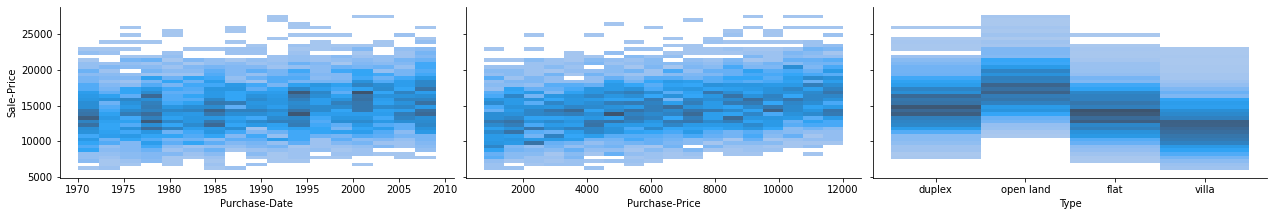

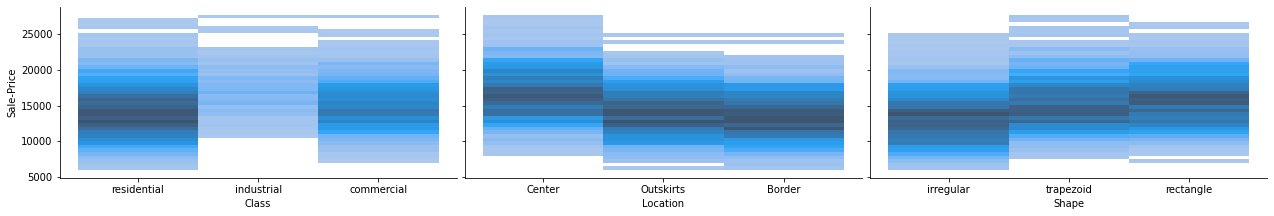

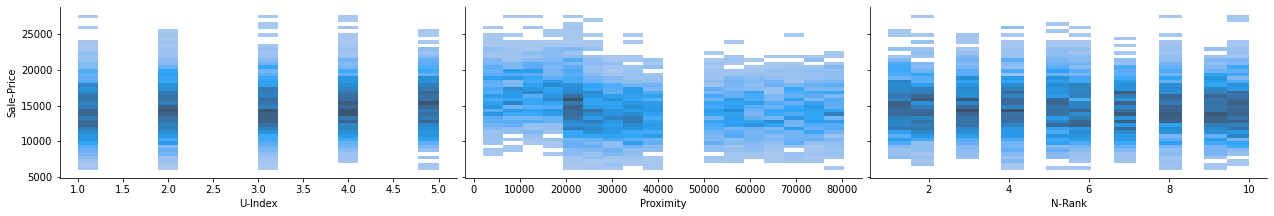

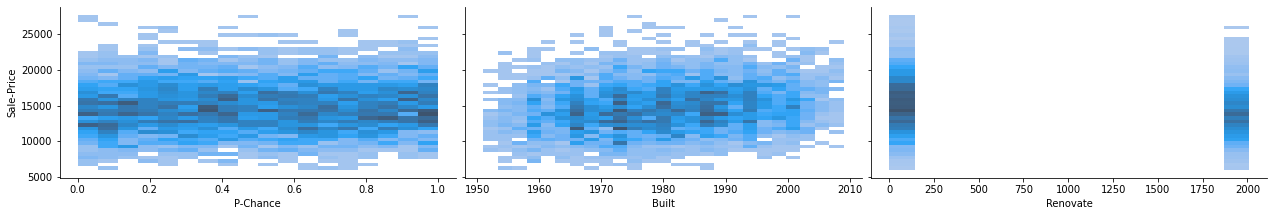

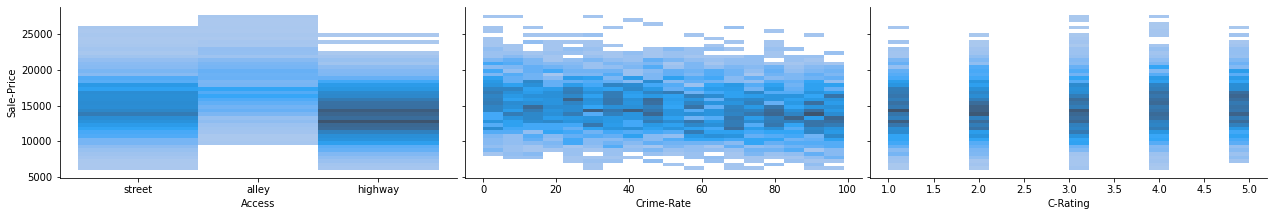

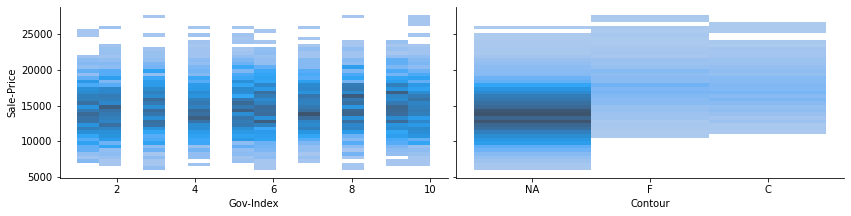

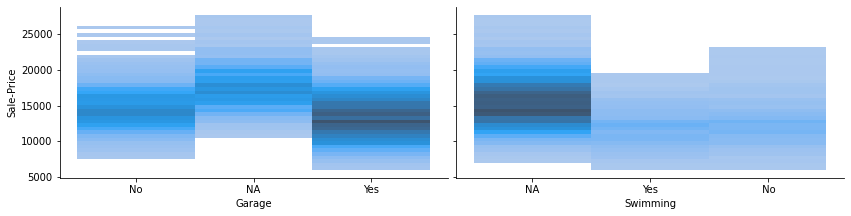

In [6]:
df = pd.read_csv('Group_13_B.csv', delimiter = ',',keep_default_na=False) # Read and keep NA in file as values non NaNs
# Assuming there are no outliers in dataset B 
# To apply Exploratory Data Analysis, all columns used must be numerical. To fix this:
# *Purchase-Date* is converted to numerical for graphing:
df["Purchase-Date"] = df["Purchase-Date"].apply(lambda x: x.replace("-","").lstrip("Jan").lstrip("January")
                                               .lstrip("Feb").lstrip("February").lstrip("Mar").lstrip("March")
                                               .lstrip("Apr").lstrip("April").lstrip("Jun").lstrip("June")
                                               .lstrip("Jul").lstrip("July").lstrip("Aug").lstrip("August")
                                               .lstrip("Sep").lstrip("September").lstrip("Oct").lstrip("October")
                                               .lstrip("Nov").lstrip("November").lstrip("Dec")
                                                .lstrip("December")).apply(pd.to_numeric)

selected_columns = df.drop(columns=["Sale-Price"]) # dropping the output 
# Divide the inputs to seperate them (to look better when graphed)
X1 = selected_columns.iloc[:,:3]
X2 = selected_columns.iloc[:,3:6]
X3 = selected_columns.iloc[:,6:9]
X4 = selected_columns.iloc[:,9:12]
X5 = selected_columns.iloc[:,12:15]
X6 = selected_columns.iloc[:,15:17] 
X7 = selected_columns.iloc[:,17:] 

# pairplot with histograms (3d bivariate) are used to depict the relationship between each input and the output
# 3d bivariate histogram was chosen since it is aesthetically pleasing and can be used for both num/catg
plt.figure()
sns.pairplot(x_vars=X1,y_vars="Sale-Price",kind="hist",height=3, aspect=2,data=df)
sns.pairplot(x_vars=X2,y_vars="Sale-Price",kind="hist",height=3, aspect=2,data=df)
sns.pairplot(x_vars=X3,y_vars="Sale-Price",kind="hist",height=3, aspect=2,data=df)
sns.pairplot(x_vars=X4,y_vars="Sale-Price",kind="hist",height=3, aspect=2,data=df)
sns.pairplot(x_vars=X5,y_vars="Sale-Price",kind="hist",height=3, aspect=2,data=df)
sns.pairplot(x_vars=X6,y_vars="Sale-Price",kind="hist",height=3, aspect=2,data=df)
sns.pairplot(x_vars=X7,y_vars="Sale-Price",kind="hist",height=3, aspect=2,data=df)
plt.show()

## Task-3

In [7]:
## Before displaying the correlation, I need to consider the categorical columns by encoding them
# The categorical columns should not be dropped. Rather, it should be converted to numerical and nominal
# The categorical columns are converted below:

# Encoding
# Below: mapping, label encoder are used for conversion

# Type column should be converted to numericals for further analysis. 
print(df["Type"].unique())
# Using custom encoding (since the types imply an order, assume that villa is most luxurious, open land is least)
Type_mapping = {'villa':1,'duplex':2,'flat':3,'open land':4}
df["Type"] = df["Type"].map(Type_mapping)
# Using label encoder
encoder = LabelEncoder()
print(df["Class"].unique()) # 0: commercial, 1: industrial, 2: residential (alphabetically)
df["Class"] = encoder.fit_transform(df["Class"]) 
print(df["Location"].unique()) # Border:0, Center:1, Outskirts:2 (alphabetically)
df["Location"] = encoder.fit_transform(df["Location"]) 
print(df["Shape"].unique()) # irregular:0, rectangle:1, trapezoid:2 (alphabetically)
df["Shape"] = encoder.fit_transform(df["Shape"]) 
print(df["Access"].unique()) # alley:0, highway:1, street:2 (alphabetically)
df["Access"] = encoder.fit_transform(df["Access"]) 

print(df["Contour"].unique())
Contour_mapping = {'NA':0,'F':1,'C':2} # 0 means it is not applicable to have a value here
df["Contour"] = df["Contour"].map(Contour_mapping)
print(df["Garage"].unique())
Garage_mapping = {'NA':0,'Yes':1,'No':2} # 0 means it is not applicable to have a value here
df["Garage"] = df["Garage"].map(Garage_mapping)
print(df["Swimming"].unique())
Swimming_mapping = {'NA':0,'Yes':1,' No':2} # 0 means it is not applicable to have a value here
df["Swimming"] = df["Swimming"].map(Swimming_mapping)

# to put the sale-price as the last column (output)
df["SP"] = df["Sale-Price"]
df.drop(columns="Sale-Price", inplace=True)
df["Sale-Price"] =df["SP"]
df.drop(columns="SP", inplace=True)

# Now all columns are included as numerical to be analyzed in the correlation analysis
corr = df.corr()
display(corr.style.background_gradient(cmap='coolwarm').set_precision(4))
# display(corr) #if the style doesn't work 
corr=corr.apply(lambda x: np.abs(x)) # to get absolutes
sorted_corr = corr.sort_values(by=['Sale-Price'], ascending=False) # negative values will be considered using abs.
# sort by Sale-Price to get what variables are correlated with Sale-Price
sorted_corr = sorted_corr['Sale-Price'].index # store the indecies here to sort them next
print('The top three input variables correlated with the Sale-Price are: ',sorted_corr[1:4].tolist())
print('The least three input variables correlated with the Sale-Price are: ',sorted_corr[17::].tolist())
df
#---
## The following 3 columns *Contour*,*Garage*,*Swimming* are only applicable for certain *Type*. 
# For example, *Swimming* is only applicable for "Villa" *Type*. This might cause an issue in the upcoming analysis 
# because many rows will be with the value NA. As a result, the analysis might not produce weak results 
# The correlation might show innacurate results. Also, the PCA might be affected as well
# For those reasons, these 3 columns will be dropped from further analysis
# For now, I will keep them as categorical columns

['duplex' 'open land' 'flat' 'villa']
['residential' 'industrial' 'commercial']
['Center' 'Outskirts' 'Border']
['irregular' 'trapezoid' 'rectangle']
['street' 'alley' 'highway']
['NA' 'F' 'C']
['No' 'NA' 'Yes']
['NA' 'Yes' ' No']


,Purchase-Date,Purchase-Price,Type,Class,Location,Shape,U-Index,Proximity,N-Rank,P-Chance,Built,Renovate,Access,Crime-Rate,C-Rating,Gov-Index,Contour,Garage,Swimming,Sale-Price
Purchase-Date,1.0000,0.0120,0.0043,-0.0065,0.0230,-0.0013,0.0083,0.0198,0.0116,-0.0176,0.8920,-0.0132,-0.0010,0.0040,-0.0022,0.0012,0.0042,-0.0035,0.0000,0.1901
Purchase-Price,0.0120,1.0000,-0.0074,0.0058,-0.0037,-0.0144,-0.0067,0.0076,-0.0030,0.0118,0.0204,-0.0124,-0.0128,0.0125,-0.0212,-0.0147,0.0127,-0.0144,0.0168,0.3209
Type,0.0043,-0.0074,1.0000,-0.3609,0.0137,0.0062,-0.0238,0.0030,-0.0023,-0.0094,0.0031,-0.3307,0.0146,-0.0136,-0.0108,0.0216,0.7167,-0.4581,-0.7173,0.4937
Class,-0.0065,0.0058,-0.3609,1.0000,-0.0041,-0.0037,0.0007,-0.0065,-0.0038,0.0173,-0.0022,0.0506,-0.0027,0.0065,-0.0004,0.0028,-0.1356,-0.0026,0.4355,-0.1205
Location,0.0230,-0.0037,0.0137,-0.0041,1.0000,0.0183,-0.0004,0.6330,-0.0109,-0.0153,0.0283,-0.0025,-0.3090,0.0201,-0.0014,0.0051,0.0188,-0.0070,-0.0142,0.0688
Shape,-0.0013,-0.0144,0.0062,-0.0037,0.0183,1.0000,0.0054,0.0113,-0.0300,-0.0110,-0.0121,-0.0047,0.0128,-0.0273,-0.0026,-0.0220,0.0139,0.0111,-0.0086,0.2716
U-Index,0.0083,-0.0067,-0.0238,0.0007,-0.0004,0.0054,1.0000,-0.0051,-0.0037,-0.0381,0.0112,0.0086,-0.0102,0.0002,-0.0031,-0.0121,-0.0367,0.0268,-0.0012,0.0895
Proximity,0.0198,0.0076,0.0030,-0.0065,0.6330,0.0113,-0.0051,1.0000,-0.0234,-0.0028,0.0222,-0.0063,-0.0798,0.0083,-0.0163,0.0147,0.0163,-0.0042,-0.0013,-0.2240
N-Rank,0.0116,-0.0030,-0.0023,-0.0038,-0.0109,-0.0300,-0.0037,-0.0234,1.0000,0.0091,0.0133,0.0064,0.0032,-0.0080,0.0248,0.0211,0.0071,-0.0044,-0.0056,-0.0310
P-Chance,-0.0176,0.0118,-0.0094,0.0173,-0.0153,-0.0110,-0.0381,-0.0028,0.0091,1.0000,-0.0182,0.0121,0.0226,0.0002,0.0178,0.0051,-0.0205,0.0157,0.0111,0.0507


The top three input variables correlated with the Sale-Price are:  ['Type', 'Contour', 'Swimming']
The least three input variables correlated with the Sale-Price are:  ['C-Rating', 'P-Chance', 'N-Rank']


,Purchase-Date,Purchase-Price,Type,Class,Location,Shape,U-Index,Proximity,N-Rank,P-Chance,Built,Renovate,Access,Crime-Rate,C-Rating,Gov-Index,Contour,Garage,Swimming,Sale-Price
0,1975,2474.5,2,2,1,0,2,8171,10,0.473210,1964,1973,2,59,3,4,0,2,0,11896.0
1,1991,2414.2,4,1,1,0,5,10290,1,0.064744,1979,0,0,24,3,1,1,0,0,17187.2
2,1989,2453.3,2,2,1,0,5,9940,8,0.115741,1983,0,2,94,3,5,0,2,0,12756.4
3,1973,2513.7,4,0,2,2,5,69542,4,0.300323,1967,0,1,68,1,9,2,0,0,14722.9
4,1981,8691.7,4,1,1,2,1,3328,5,0.017304,1962,0,2,88,4,8,1,0,0,17694.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1983,6337.5,2,0,1,2,5,9507,8,0.432669,1968,1977,2,88,2,2,0,2,0,15072.4
4996,2004,11209.0,2,0,0,0,2,20864,8,0.009118,1988,1998,1,6,4,6,0,2,0,13823.7
4997,1997,1604.4,3,0,2,2,3,78957,7,0.561522,1987,1997,1,83,3,8,0,2,0,11828.1
4998,2006,7111.0,3,2,1,2,4,11546,8,0.011843,2006,0,0,16,4,5,0,1,0,19046.1


In [8]:
# Before doing Task 4
df = pd.read_csv('Group_13_B.csv', delimiter = ',',keep_default_na=False) # Read and keep NA in file as values non NaNs
# rereading the original df. Mainly, the PCA showed week seperation when I included the
# nominal columns that were converted using label encoding/one hot encoding. 
# To overcome this, even though I will be sacrificing some information, more accurate information will be gained

## The following 3 columns *Contour*,*Garage*,*Swimming* are only applicable for certain *Type*. 
# For example, *Swimming* is only applicable for "Villa" *Type*. This have caused an issue in PC analysis
# because many rows will be with the value NA. As a result, the PC analysis have produced weak results 
# For those reasons, these 3 columns will be ignored in the PC analysis
#------------------------------------------------------------------------------------------------------
df["Purchase-Date"] = df["Purchase-Date"].apply(lambda x: x.replace("-","").lstrip("Jan").lstrip("January")
                                               .lstrip("Feb").lstrip("February").lstrip("Mar").lstrip("March")
                                               .lstrip("Apr").lstrip("April").lstrip("Jun").lstrip("June")
                                               .lstrip("Jul").lstrip("July").lstrip("Aug").lstrip("August")
                                               .lstrip("Sep").lstrip("September").lstrip("Oct").lstrip("October")
                                               .lstrip("Nov").lstrip("November").lstrip("Dec")
                                                .lstrip("December")).apply(pd.to_numeric)

# Type column should be converted to numericals for PCA analysis. 
# Using custom encoding (since the types imply an order, assume that villa is most luxurious, open land is least)
Type_mapping = {'villa':1,'duplex':2,'flat':3,'open land':4}
df["Type"] = df["Type"].map(Type_mapping)
# Using label encoder
encoder = LabelEncoder()
df["Class"] = encoder.fit_transform(df["Class"]) # 0: commercial, 1: industrial, 2: residential (alphabetically)
df["Location"] = encoder.fit_transform(df["Location"]) # Border:0, Center:1, Outskirts:2 (alphabetically)
df["Shape"] = encoder.fit_transform(df["Shape"]) # irregular:0, rectangle:1, trapezoid:2 (alphabetically)
df["Access"] = encoder.fit_transform(df["Access"]) # alley:0, highway:1, street:2 (alphabetically)
# to put the sale-price as the last column (output)
df["SP"] = df["Sale-Price"]
df.drop(columns="Sale-Price", inplace=True)
df["Sale-Price"] =df["SP"]
df.drop(columns="SP", inplace=True)
df

,Purchase-Date,Purchase-Price,Type,Class,Location,Shape,U-Index,Proximity,N-Rank,P-Chance,Built,Renovate,Access,Crime-Rate,C-Rating,Gov-Index,Contour,Garage,Swimming,Sale-Price
0,1975,2474.5,2,2,1,0,2,8171,10,0.473210,1964,1973,2,59,3,4,NA,No,NA,11896.0
1,1991,2414.2,4,1,1,0,5,10290,1,0.064744,1979,0,0,24,3,1,F,NA,NA,17187.2
2,1989,2453.3,2,2,1,0,5,9940,8,0.115741,1983,0,2,94,3,5,NA,No,NA,12756.4
3,1973,2513.7,4,0,2,2,5,69542,4,0.300323,1967,0,1,68,1,9,C,NA,NA,14722.9
4,1981,8691.7,4,1,1,2,1,3328,5,0.017304,1962,0,2,88,4,8,F,NA,NA,17694.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1983,6337.5,2,0,1,2,5,9507,8,0.432669,1968,1977,2,88,2,2,NA,No,NA,15072.4
4996,2004,11209.0,2,0,0,0,2,20864,8,0.009118,1988,1998,1,6,4,6,NA,No,NA,13823.7
4997,1997,1604.4,3,0,2,2,3,78957,7,0.561522,1987,1997,1,83,3,8,NA,No,NA,11828.1
4998,2006,7111.0,3,2,1,2,4,11546,8,0.011843,2006,0,0,16,4,5,NA,Yes,NA,19046.1


## Task-4

<Figure size 432x288 with 0 Axes>

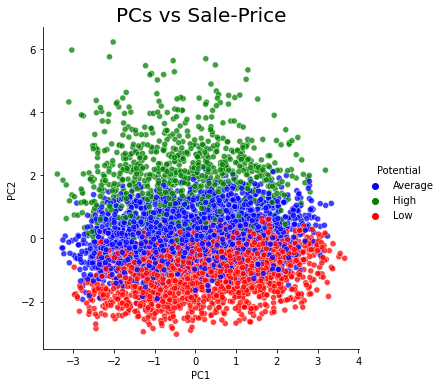

The two PCs show that the inputs provide a good separation of high and low performing estates, 
with some overlap. even without using Sale-Price as an input. 
In general, the more you go up, the more likely the estate has high potential


,Purchase-Date,Purchase-Price,Type,Class,Location,Shape,U-Index,Proximity,N-Rank,P-Chance,...,Access,Crime-Rate,C-Rating,Gov-Index,Contour,Garage,Swimming,Sale-Price,Appreciation/Depreciation,Potential
0,1975,2474.5,2,2,1,0,2,8171,10,0.473210,...,2,59,3,4,NA,No,NA,11896.0,3.807436,Average
1,1991,2414.2,4,1,1,0,5,10290,1,0.064744,...,0,24,3,1,F,NA,NA,17187.2,6.119211,High
2,1989,2453.3,2,2,1,0,5,9940,8,0.115741,...,2,94,3,5,NA,No,NA,12756.4,4.199690,High
3,1973,2513.7,4,0,2,2,5,69542,4,0.300323,...,1,68,1,9,C,NA,NA,14722.9,4.857063,High
4,1981,8691.7,4,1,1,2,1,3328,5,0.017304,...,2,88,4,8,F,NA,NA,17694.9,1.035839,Average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1983,6337.5,2,0,1,2,5,9507,8,0.432669,...,2,88,2,2,NA,No,NA,15072.4,1.378288,Average
4996,2004,11209.0,2,0,0,0,2,20864,8,0.009118,...,1,6,4,6,NA,No,NA,13823.7,0.233268,Low
4997,1997,1604.4,3,0,2,2,3,78957,7,0.561522,...,1,83,3,8,NA,No,NA,11828.1,6.372289,High
4998,2006,7111.0,3,2,1,2,4,11546,8,0.011843,...,0,16,4,5,NA,Yes,NA,19046.1,1.678400,Average


In [10]:
# To apply PCA, all inputs must be numerical. 
# The categorical columns should not be dropped. Rather, it should be converted to numerical and nominal
# The categorical columns that are used were converted above, the rest were ignored ONLY here (last 3 columns):
num_columns = df.select_dtypes(exclude='object').columns # numerical columns
pca_input_columns = num_columns.drop(["Sale-Price"]) # only numerical and drop the output

# Before doing PCA, the data appear to have different numerical scales. To fix this, normalization is needed
#--------
pca = PCA(n_components=2) # create object (2 is how many principal components)
principalComponents = pca.fit_transform(StandardScaler().fit_transform(df[pca_input_columns])) # Standardize
# by using standard scaler, I optained more accurate results
df['PC1'] = principalComponents[:,0] 
df['PC2'] = principalComponents[:,1] 

# Classify the performance based on the (appreciation and depreciation) level
df["Appreciation/Depreciation"] = (df["Sale-Price"] - df["Purchase-Price"]) / df["Purchase-Price"] # formula
df["Potential"] = df["Appreciation/Depreciation"].apply(lambda x: "Low" if x<= 1 else 
                                                          ("High" if x >= 4 else "Average"))
Potential = df["Potential"] # keeping a copy for graphing next (in task 5-6)
plt.figure()
# This scatter plot shows the efficency of the two PCs clearly.
sns.relplot(x='PC1',y='PC2', # (NOTE: if the graph lags run this cell twice)
            hue="Potential", palette=["b","g","r"],  
            kind='scatter',alpha=0.75,
            height=5, aspect=1,
            data=df)
plt.title('PCs vs Sale-Price', fontsize = 20)
plt.show()
print(f'''The two PCs show that the inputs provide a good separation of high and low performing estates, 
with some overlap. even without using Sale-Price as an input. 
In general, the more you go up, the more likely the estate has high potential''')
df.drop(columns=['PC1','PC2'],inplace=True)
display(df)

## Task-5

<Figure size 432x288 with 0 Axes>

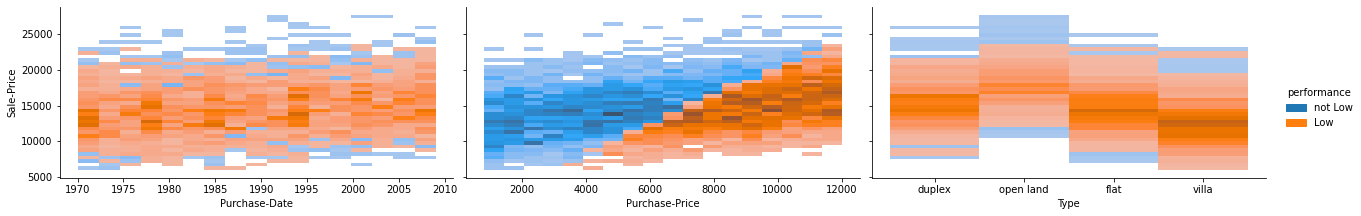

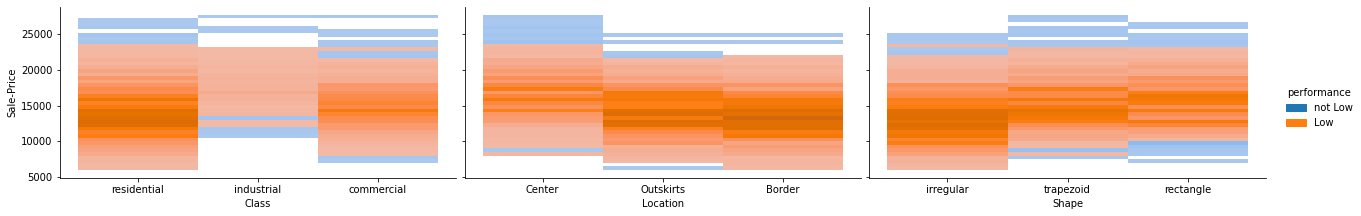

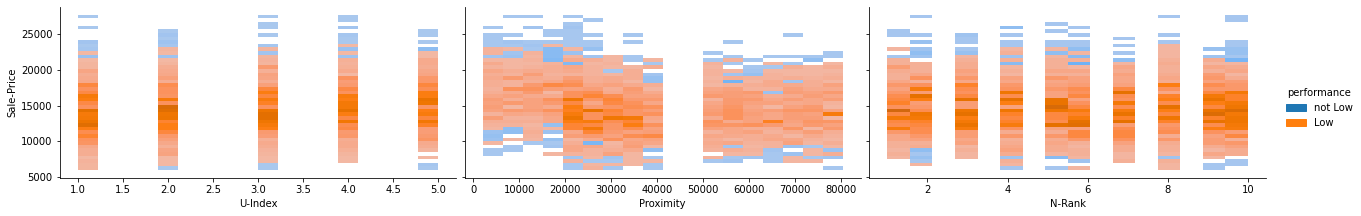

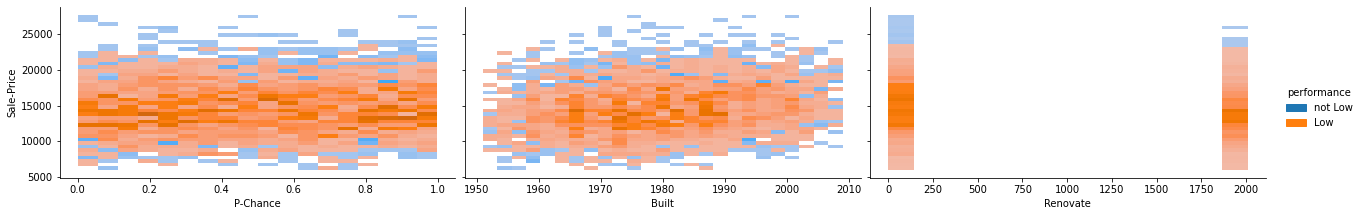

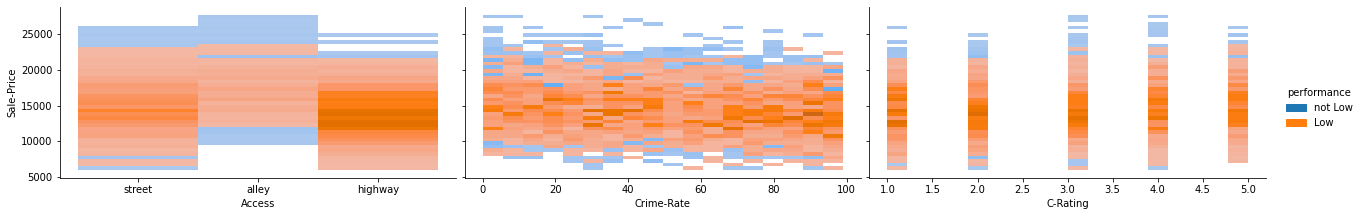

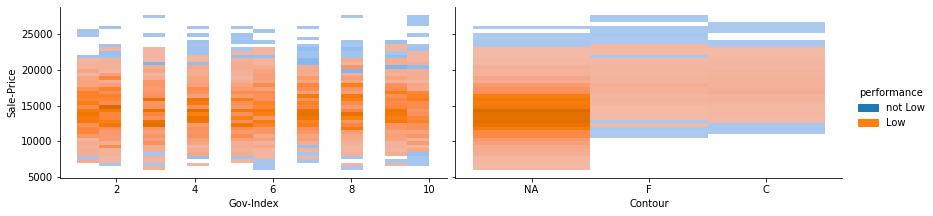

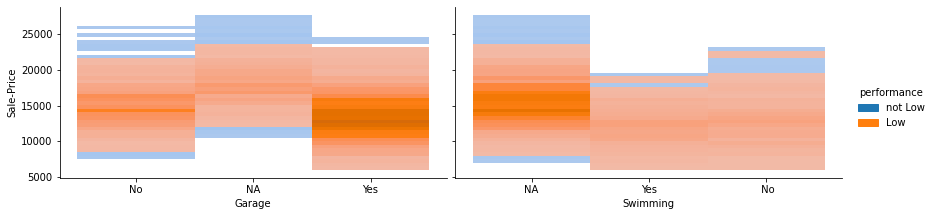

The purchase date does not seem to show a certain pattern for low performance.
Low performance is more common when the purchase price is above 6000.
Low performance is more common in Duplex, Flats, and Villas, but the type alone does not seem to determine
      the performance of the proerty
Low performance is more common in residential (legal classification of the property).
Low performance is more common in properties nearby the border of the city.
Low performance is more common in irregular property shape.
Utilities Index does not seem to show a certain pattern for low performance.
Low performance is more common in Proximity to metro stationof approximately 20,000, but doesn't seem to have a
    strong pattern
Low performance is more common in neighborhood facilities of rank 5, but doesn't seem to show a
    strong pattern
Probability of finding parking space on adjacent roads
      does not seem to show a certain pattern for low performance.
Year of construction does not seem to sh

In [11]:
# Rather than creating a new df, (reread th the file for graphing) and do the same as previous steps
# reread the file for graphing
df = pd.read_csv('Group_13_B.csv', delimiter = ',',keep_default_na=False) # Read and keep NA in file as values non NaNs
selected_columns = df.drop(columns=["Sale-Price"]) # dropping the output 
df["Purchase-Date"] = df["Purchase-Date"].apply(lambda x: x.replace("-","").lstrip("Jan").lstrip("January")
                                               .lstrip("Feb").lstrip("February").lstrip("Mar").lstrip("March")
                                               .lstrip("Apr").lstrip("April").lstrip("Jun").lstrip("June")
                                               .lstrip("Jul").lstrip("July").lstrip("Aug").lstrip("August")
                                               .lstrip("Sep").lstrip("September").lstrip("Oct").lstrip("October")
                                               .lstrip("Nov").lstrip("November").lstrip("Dec")
                                                .lstrip("December")).apply(pd.to_numeric)
# Divide the inputs to seperate them (to look better when graphed)
X1 = selected_columns.iloc[:,:3]
X2 = selected_columns.iloc[:,3:6]
X3 = selected_columns.iloc[:,6:9]
X4 = selected_columns.iloc[:,9:12]
X5 = selected_columns.iloc[:,12:15]
X6 = selected_columns.iloc[:,15:17] 
X7 = selected_columns.iloc[:,17:] 
#----------------------------------------------------------------------
# I created 'performance' column for seperating low performance estates
df['performance'] = Potential == "Low"
df['performance']= df['performance'].apply(lambda x: "Low" if x else "not Low")

# I choosed histograms (3d bivariate) because it clearly shows where tha data is concentrated. 
# This helped my to identify the pattern easily.
plt.figure()
sns.pairplot(x_vars=X1,y_vars="Sale-Price",kind="hist",height=3, aspect=2,data=df,hue="performance")
sns.pairplot(x_vars=X2,y_vars="Sale-Price",kind="hist",height=3, aspect=2,data=df,hue="performance")
sns.pairplot(x_vars=X3,y_vars="Sale-Price",kind="hist",height=3, aspect=2,data=df,hue="performance")
sns.pairplot(x_vars=X4,y_vars="Sale-Price",kind="hist",height=3, aspect=2,data=df,hue="performance")
sns.pairplot(x_vars=X5,y_vars="Sale-Price",kind="hist",height=3, aspect=2,data=df,hue="performance")
sns.pairplot(x_vars=X6,y_vars="Sale-Price",kind="hist",height=3, aspect=2,data=df,hue="performance")
sns.pairplot(x_vars=X7,y_vars="Sale-Price",kind="hist",height=3, aspect=2,data=df,hue="performance")
plt.show()

df.drop(columns='performance',inplace=True)
#-----------------------------------------------------------------------------------
# The patterns of Low performance are explained in extensive detail below:
### Sale-price Vs Purchase-date:
print(f'The purchase date does not seem to show a certain pattern for low performance.')
# the low performance is more common at the sale price between 10-15 thousand.
# and the concentration of not low gets higher the more the sale-price moves away from this value.

### Sale-price Vs Purchase-price:
print(f'Low performance is more common when the purchase price is above 6000.') 
# The low performance is more common when the purchase-price increases. 
# At the sale price between 10-15 thousand and purchase price between 4-8 thousand, 
# there is a high fluctuation in the performance.

### Sale-price Vs Type:
print(f'''Low performance is more common in Duplex, Flats, and Villas, but the type alone does not seem to determine
      the performance of the proerty''')
# Especially with sale price of 10,000 - 15,000
# Even though this is not expected, but the estates with low performance are clustered in these types  
# The duplexes-open lands-flats-villas. Have a not low performance mostly at lower sale price.
# And have high concentration of low performance at medium sale price.
# And at a low sale price, the vila type has low performance.

### Sale-price Vs Class:
print(f'Low performance is more common in residential (legal classification of the property).')
# This showes that the class can infact affect the performance of the property
# The residential class has a high concentration of low performance at intermediate sale price. 
# Low performance at low sale price except for the residential. 
# The industrial class has a weak concentration of low performance at different sale prices. 
# The commercial class has approximately the same distribution as the residential class.

### Sale-price Vs Location:
print(f'Low performance is more common in properties nearby the border of the city.')
# low performance is very common at Intermediate sale price despite the location.

### Sale-price Vs Shape:
print(f'Low performance is more common in irregular property shape.')
# At the intermediate sale price, low performance is very common despite the shape.

### Sale-price Vs U-index:
print(f'Utilities Index does not seem to show a certain pattern for low performance.')
# At the sale price from 10000 to 20000 the low performance is common among U Indecies from 1 to 5

### Sale-price Vs Proximity:
print(f"""Low performance is more common in Proximity to metro stationof approximately 20,000, but doesn't seem to have a
    strong pattern""")
# The low performance is common in the intermediate sale-price and less common.

### Sale-price Vs N-Rank:
print(f"""Low performance is more common in neighborhood facilities of rank 5, but doesn't seem to show a
    strong pattern""")
#Regardless of the rank, low performance is common at intermediate price.

### Sale-price Vs P-Chance:
print(f'''Probability of finding parking space on adjacent roads
      does not seem to show a certain pattern for low performance.''')
# Regardless of the P-Chance, low performance is common at intermediate price. 

### Sale-price Vs The year of construction(Built):
print(f'Year of construction does not seem to show a certain pattern for low performance.')
# Low performance is common at intermediate pice in the years from 1965 to 1995. 

### Sale-price Vs Renovate:
print(f"Low performance is equally common in properties that were renovated and those that weren't.")
# Renovation does not tell much about the performance

### Sale-price Vs Access:
print(f'Low performance is more common in Highway (direct access to the property)')

### Sale-price Vs Crime-Rate:
print(f'''Average number of crimes reported per year in the neighborhood does not seem to affect the performance
      of the property.''')
# At high price the low performance is less common despite the crime-rate.
# the crime rate does not tell much about the performance.
# low performance is more common among intermediate prices.

### Sale-price Vs C-Rating:
print(f'Pleasantness of the climate throughout the year does not seem to affect the performance much.')
# At high and low price low performance is uncommon, and in intermediate price the low performance is very common. 

### Sale-price Vs Gov-Index:
print(f'''Low performace is more common in properties with Gov-Index of 1-2
      (Expected level of government infrastructure project).''')

### Sale-price Vs Contour:
print(f'''Low performance is more common in properties at which it is not applicable to to have flatness of property
      (i.e. Villa, Flat, and Duplex.''')
# for F and C, the low performance exists in low concentration from approximately 13 to 21 thousands.
# otherwise there is no to little low performance in open land

### Sale-price Vs Garage:
print(f'Low performance is more common in properties that have a garage.')
# for no garage, there is no low performance above 22500 and below 8000 and the low concentration is common at 15000
# for NA there is no low performance at more than 23500 and below 11000 and low performance is from 13000-23000
# for properties with Garages, the low performance is very high from 10-15 thosand and doesn't exist above 24000

### Sale-price Vs Swimming:
print(f'Low performance is more common in properties at which it is not applicable to to have a swimming pool.')
#with NA at intermediate price, low is very common and it gets less common the more it moved from intermediate price
#It seems like with swimming or without there will be no major effect on the performance. 

## Task-6

<Figure size 432x288 with 0 Axes>

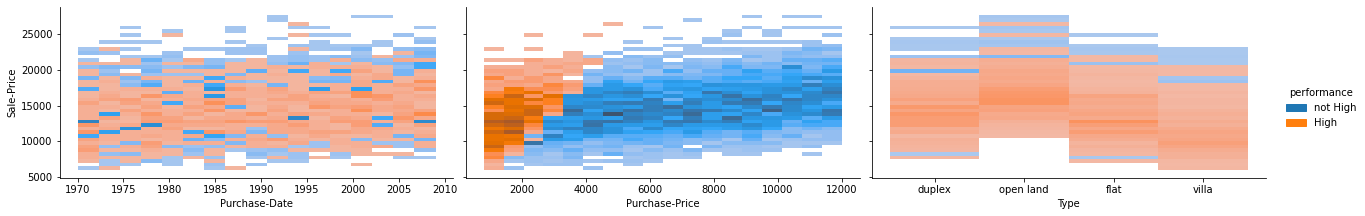

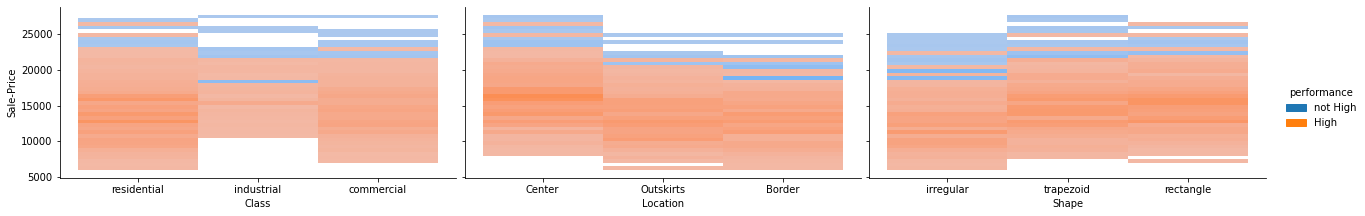

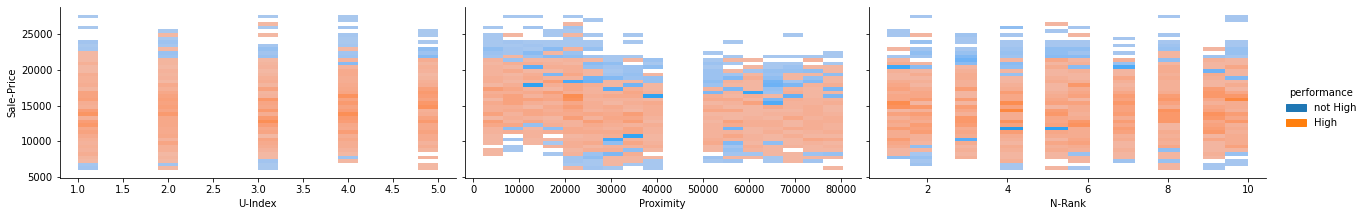

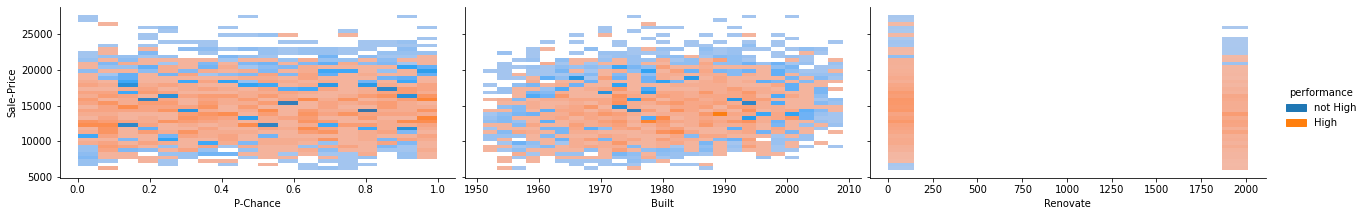

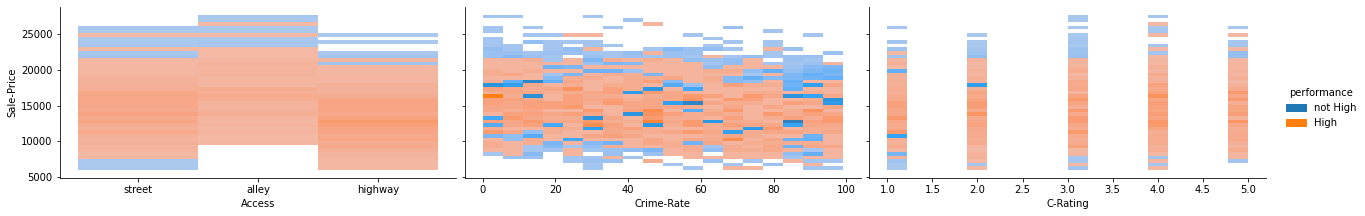

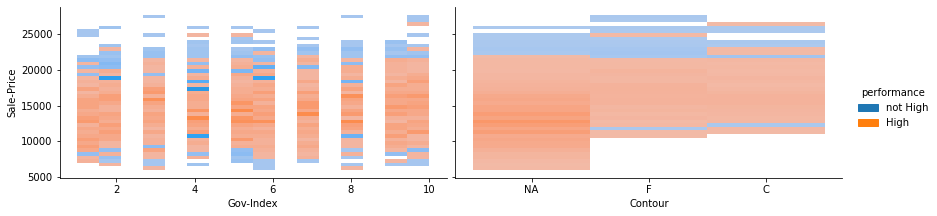

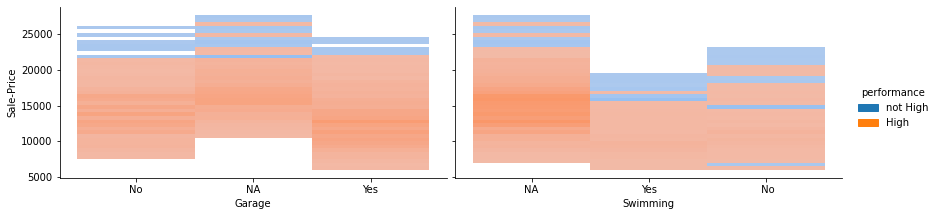

The purchase date does not seem to show a certain pattern for high performance.
High performance is more common in properties with purchase price below 4000
High performance is more common in open land, but the type alone does not seem to determine
      the performance of the proerty
High performance is also more common in residential (legal classification of the property).
High performance is more common in properties nearby the center of the city.
High performance is more common in rectangle property shape.
High performance is somewhat more common in U-Index of 5, but in general,
      Utilities Index does not seem to show a certain pattern for high performance.
Proximity to metro station does not seem to show a certain patter for high performing properties
High performance is more common in neighborhood facilities of rank 1
Probability of finding parking space on adjacent roads does not seem to show a certain pattern
for high performance. Yet, when there is a guaranteed availabilit

In [12]:
# I created 'performance' column for seperating high performance
df['performance'] = Potential == "High"
df['performance']=df['performance'].apply(lambda x: "High" if x else "not High")

# I choosed histograms (3d bivariate) because it clearly shows where tha data is concentrated. 
# This helped my to identify the pattern easily.
plt.figure()
sns.pairplot(x_vars=X1,y_vars="Sale-Price",kind="hist",height=3, aspect=2,data=df,hue="performance")
sns.pairplot(x_vars=X2,y_vars="Sale-Price",kind="hist",height=3, aspect=2,data=df,hue="performance")
sns.pairplot(x_vars=X3,y_vars="Sale-Price",kind="hist",height=3, aspect=2,data=df,hue="performance")
sns.pairplot(x_vars=X4,y_vars="Sale-Price",kind="hist",height=3, aspect=2,data=df,hue="performance")
sns.pairplot(x_vars=X5,y_vars="Sale-Price",kind="hist",height=3, aspect=2,data=df,hue="performance")
sns.pairplot(x_vars=X6,y_vars="Sale-Price",kind="hist",height=3, aspect=2,data=df,hue="performance")
sns.pairplot(x_vars=X7,y_vars="Sale-Price",kind="hist",height=3, aspect=2,data=df,hue="performance")
plt.show()

df.drop(columns='performance',inplace=True)
#-----------------------------------------------------------------------------------
# The patterns of High performance are explained in extensive detail below:
### Sale-price Vs Purchase-Date:
print(f'The purchase date does not seem to show a certain pattern for high performance.')

### Sale-price Vs Purchase-Price:
print(f'High performance is more common in properties with purchase price below 4000')
#After 4000 There is no high performance. concentration of high and not high increase in the intermediate sale-price.

### Sale-price Vs Type:
print(f'''High performance is more common in open land, but the type alone does not seem to determine
      the performance of the proerty''')
# for duplexes-open lands-vilas-flats the high performance is in common in the high sale-price region.
# The high performance is more common at the sale price between 10-20 thousands for all types.

### Sale-price Vs Class:
print(f'High performance is also more common in residential (legal classification of the property).')
# This showes that the class can infact affect the performance of the property
# Despite the class, high performance is more common below 20000 sale-price.

### Sale-price Vs location:
print(f'High performance is more common in properties nearby the center of the city.')
#Despite the location, the high performance is  more common below 20000 sale price.
#and between 10 -15 thousands the high tends to be more common

### Sale-price Vs Shape:
print(f'High performance is more common in rectangle property shape.')
#the high performance is concentrated more at sale price between 10-15 thousands.
#and gets less common the more the sale price diverges grom this value, above 20000 sale price.

### Sale-price Vs U-Index:
print(f'''High performance is somewhat more common in U-Index of 5, but in general,
      Utilities Index does not seem to show a certain pattern for high performance.''')
#The high performance is common at price from 7000 to 22000 for all U-inexes.
#for 1 2 3 4 indexes there is some non existence of high performance in around 5000 sale price.

### Sale-price Vs Proximity:
print(f"Proximity to metro station does not seem to show a certain patter for high performing properties")

### Sale-price Vs N-Rank:
print(f'High performance is more common in neighborhood facilities of rank 1')

### Sale-price Vs P-Chance:
print(f'''Probability of finding parking space on adjacent roads does not seem to show a certain pattern
for high performance. Yet, when there is a guaranteed availability of parking space, it's usally a high performing''')
#The high performance is common between 10-20 thousands with some differences in some areas

### Sale-price Vs Construction year(Built):
print(f'Year of construction does not seem to show a certain pattern for high performance.')
#At years before the 1960s the high performance seems uncommon despite the sale price.
#between the year 1970 and 2005 the high performance is more common between 9000 to 18000 price
#After the year 2005 there is a weak concentration of high performance.

### Sale-price Vs Renovate:
print(f"High performance is more common in properties that were not renovated.")
# Renovation does not tell much about the performance
# At high price the high performnce is uncommon, and in the 
# Unrenovated estates seem to have approximately the same distribution of high and not high performance 

### Sale-price Vs Access:
print(f'High performance is somewhat more common in street (direct access to the property)')
# In Street, below 6000 sale price the high performance does not exist.
# While between 6000 and 20000 the high performance is common for all the access ways 

### Sale-price Vs Crime-Rate:
print(f'''Average number of crimes reported per year in the neighborhood does not seem to affect the performance
      of the property.''')
#At low and high sale price the high performance is uncommon despite the crime rate, and between 10 to 20000, 
#the high performance is more common over all the rates with some exceptions.

### Sale-price Vs C-Rating:
print(f'High performance is more common when pleasantness of the climate is at C-Rating of (4-5)') 
#At low price  and high price, high performance is uncommon at all ratings. And in intermediate price the high 

### Sale-price Vs Gov-Index:
print(f'''High performace is more common in properties with Gov-Index of 9-10
      (Expected level of government infrastructure project).''')

### Sale-price Vs Contour:
print(f'''High performance is more common in properties at which it is not applicable to to have flatness of property
      (i.e. Villa, Flat, and Duplex.''')
# This shows that the Contour does not tell much alone

### Sale-price Vs Garage:
print(f'High performance is somewhat common in properties that do not have a garage.')
# for no garage, the performance tend to be not high t more than 22500 sale price. And the same goes for estates 
#with garages. and for NA values the performance fluctuates between high and not high above 20000 sale price. 

### Sale-price Vs Swimming:
print(f'High performance is more common in properties at which it is not applicable to to have a swimming pool.')
# For NA, the performance fluctuates between high and not high above 23000 and below this value the performance
# tends to be high. For Swimming, there is no data at high price but above 15 -18 thousand the price tends
#not to be high. For No swimming also, there is no data at high price. However,the performance fluctuates between high 
# Otherwise the performance tend to be high with low concentration. 

In [13]:
# Before doing (Task 7) the regression analysis:
df = pd.read_csv('Group_13_B.csv', delimiter = ',',keep_default_na=False)
# rereading last time to encode using one hot encoding to include all inputs in the regression (train file)
df["Purchase-Date"] = df["Purchase-Date"].apply(lambda x: x.replace("-","").lstrip("Jan").lstrip("January")
                                               .lstrip("Feb").lstrip("February").lstrip("Mar").lstrip("March")
                                               .lstrip("Apr").lstrip("April").lstrip("Jun").lstrip("June")
                                               .lstrip("Jul").lstrip("July").lstrip("Aug").lstrip("August")
                                               .lstrip("Sep").lstrip("September").lstrip("Oct").lstrip("October")
                                               .lstrip("Nov").lstrip("November").lstrip("Dec")
                                                .lstrip("December")).apply(pd.to_numeric)
hot_df = pd.get_dummies(df, columns=['Class','Location','Shape','Access','Contour','Garage','Swimming']
                        ,drop_first=True)
Type_mapping = {'villa':1,'duplex':2,'flat':3,'open land':4}
hot_df["Type"] = df["Type"].map(Type_mapping)
hot_df["SP"] = hot_df["Sale-Price"]
hot_df.drop(columns="Sale-Price", inplace=True)
hot_df["Sale-Price"] = hot_df["SP"]
hot_df.drop(columns="SP", inplace=True)
#---------------------------------------------------------------------------------------------------------------------
# Reading file C (the test file) and applying all previous steps to ensure consistency to predict values 
idf = pd.read_csv('Group_13_C.csv', delimiter = ',',keep_default_na=False)# Read and keep NA in file as values non NaNs
idf["Purchase-Date"] = idf["Purchase-Date"].apply(lambda x: x.replace("-","").lstrip("Jan").lstrip("January")
                                               .lstrip("Feb").lstrip("February").lstrip("Mar").lstrip("March")
                                               .lstrip("Apr").lstrip("April").lstrip("Jun").lstrip("June")
                                               .lstrip("Jul").lstrip("July").lstrip("Aug").lstrip("August")
                                               .lstrip("Sep").lstrip("September").lstrip("Oct").lstrip("October")
                                               .lstrip("Nov").lstrip("November").lstrip("Dec")
                                                .lstrip("December")).apply(pd.to_numeric)
idf = pd.get_dummies(idf, columns=['Class','Location','Shape','Access','Contour','Garage','Swimming']
                        ,drop_first=True)
idf["Type"] = idf["Type"].map(Type_mapping)
idf["SP"] = idf["Sale-Price"]
idf.drop(columns="Sale-Price", inplace=True)
idf["Sale-Price"] =idf["SP"]
idf.drop(columns="SP", inplace=True)
#-----------------------------------------------------------------------------------------------------------
# First step in doing regression analysis is to split the Train/Test datasets
# Trian/Test spliting using Sample (DataB is the train, DataC is the test)

# Using all the inputs in the X. 
X_train = hot_df.drop(columns=['Sale-Price']).values # using B file and including all inputs (after encoding)
# Using the output (Sale-Price) in the Y
y_train = hot_df['Sale-Price'].values # the values of Sale-Price in the training dataset

X_test = idf.drop(columns=['Sale-Price']).values # using C file and including all inputs (after encoding)
y_test = idf['Sale-Price'].values # the values of Sale-Price in the training dataset
#--------------------------------------------------------------------------------------------------
# After splitting the datasets, I need to normalize the values to ensure accurate results
# Scaling the Train - Test splits 
scaler = StandardScaler() # Standard scaling helped yield better regression results.
scaler.fit(np.c_[X_train,y_train])

A_train = scaler.transform(np.c_[X_train,y_train])
X_train = A_train[:,:-1]
y_train = A_train[:,-1]

A_test = scaler.transform(np.c_[X_test,y_test])
X_test = A_test[:,:-1]
y_test = A_test[:,-1]
#----------------------------------------------------------------------------------
# Finally, Testing all regression methods to find which one is more suitable for predicting (Continue below)

## Task-7

In [14]:
# To identify how all variables are related to the output, I firstly used 
## OLS (Ordinary Least Squares Linear Regression)
from sklearn.linear_model import LinearRegression
reg1 = LinearRegression().fit(X_train, y_train)
y_pred1 = reg1.predict(X_test)
print('The MSE using OLS is:', mean_squared_error(y_test, y_pred1))
MSE1= mean_squared_error(y_test, y_pred1)

The MSE using OLS is: 0.1622301783308531


## Task-8

In [15]:
# Since some inputs might be correlated with each other, I need to use Ridge regression
## Ridge
from sklearn.linear_model import RidgeCV
reg2 = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2], cv=10).fit(X_train, y_train)
y_pred2 = reg2.predict(X_test)
print('The MSE using Ridge is:', mean_squared_error(y_test, y_pred2))
MSE2 = mean_squared_error(y_test, y_pred2)

The MSE using Ridge is: 0.16221229262980064


## Task-9

In [16]:
# Because some inputs might not be really related to the output, I need to consider using Lasso regression
## Lasso
from sklearn.linear_model import LassoCV
reg3 = LassoCV(cv=10, random_state=0).fit(X_train, y_train)
y_pred3 = reg3.predict(X_test)
print('The MSE using Lasso is:', mean_squared_error(y_test, y_pred3))
MSE3 = mean_squared_error(y_test, y_pred3)
#----------------------------------------------------------------------
# To evaluate the best regression model, I select the one with smallest mean squared error
# This will provide the most accurate prediction
MSE = {"OLS":MSE1,"Ridge":MSE2,"Lasso":MSE3}
print(f'\nThe best regrssion is {min(MSE, key=MSE.get)} with MSE of: {min(MSE.values())}')
print(f'Lasso performs better than OLS and Ridge for this data.')
#--------------------------------------------------------------------
# Printing the regression coefficients:
best_beta =  np.round(reg3.coef_,2)
best_beta_0 = np.round(reg3.intercept_,2)
print(f'The best values for the estimates are :', best_beta_0, best_beta.tolist())

The MSE using Lasso is: 0.1621181495723582

The best regrssion is Lasso with MSE of: 0.1621181495723582
Lasso performs better than OLS and Ridge for this data.


## Task-10

In [17]:
# In predicting, the scaled values were used. Therefore, the inverse scale must be used 
# to get an approximation to the actual predicted value.

# The inverse scaling succeeded to provude values close to the real ones.
y_pred = scaler.inverse_transform(np.c_[X_test,y_pred3])[:,-1]

idf['Predicted_Sale-Price']= y_pred.round().astype(int) # (see the last column)
display(idf.sample(10)) # Testing the regression model with random data.

,Purchase-Date,Purchase-Price,Type,U-Index,Proximity,N-Rank,P-Chance,Built,Renovate,Crime-Rate,...,Access_highway,Access_street,Contour_F,Contour_NA,Garage_No,Garage_Yes,Swimming_NA,Swimming_Yes,Sale-Price,Predicted_Sale-Price
633,2001,5442.3,4,4,64197,9,0.952905,1983,0,39,...,1,0,0,0,0,0,1,0,17591.4,17898
1772,1973,5981.0,2,5,60620,2,0.431882,1967,0,63,...,1,0,0,1,1,0,1,0,11597.2,11932
367,2003,10556.9,4,4,29198,2,0.569132,1992,0,94,...,1,0,1,0,0,0,1,0,19421.6,19713
1999,2007,8580.7,2,3,20978,1,0.356876,2002,0,55,...,0,0,0,1,1,0,1,0,19959.1,20237
1082,2006,8316.2,2,2,23659,1,0.300254,2004,0,62,...,0,1,0,1,1,0,1,0,14044.5,14417
1241,1971,6069.8,4,2,22304,6,0.091645,1969,0,83,...,0,0,0,0,0,0,1,0,18723.7,18942
1455,1995,10489.1,3,1,9775,6,0.431867,1980,1990,48,...,0,0,0,1,1,0,1,0,18450.7,18712
234,1994,11071.5,3,5,37710,7,0.162697,1977,1986,23,...,0,1,0,1,1,0,1,0,17389.3,17601
1077,2005,11543.4,2,3,63035,3,0.025260,1993,2003,50,...,1,0,0,1,0,1,1,0,17177.3,17604
450,2001,7075.9,3,3,24450,2,0.297510,1993,0,35,...,0,1,0,1,0,1,1,0,18358.8,18874
